In [2]:
# Importations essentielles
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor

# Suppression des warnings inutiles
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)


print("Jupyter Notebook est bien configuré ! 🚀")

Jupyter Notebook est bien configuré ! 🚀


In [3]:
# Charger le dataset
df = pd.read_csv("train.csv") 

# Aperçu des données
print(df.head())

# Informations générales sur les colonnes
print(df.info())

# Statistiques sur les variables numériques
print(df.describe())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Colonnes avec valeurs manquantes :
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
Electrical         1
dtype: int64


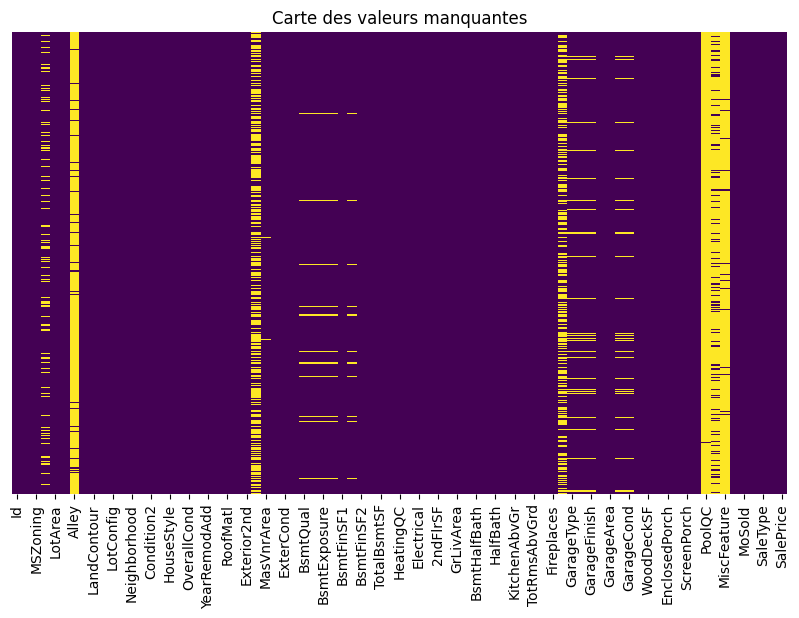

In [4]:
# Vérifier combien de colonnes ont des valeurs manquantes
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Afficher uniquement les colonnes concernées

print("Colonnes avec valeurs manquantes :")
print(missing_values.sort_values(ascending=False))

# Visualiser les valeurs manquantes avec seaborn

plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cmap="viridis", cbar=False, yticklabels=False)
plt.title("Carte des valeurs manquantes")
plt.show()

In [5]:
# Suppression des colonnes avec trop de valeurs manquantes
df = df.drop(columns=["PoolQC", "MiscFeature", "Alley", "Fence"])

# Remplacement des NaN pour les variables catégoriques (remplace NaN par "None")
cols_cat = ["GarageType", "GarageFinish", "GarageQual", "GarageCond",
            "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1", "BsmtFinType2",
            "MasVnrType"]
df[cols_cat] = df[cols_cat].fillna("None")

# Remplacement des NaN pour les variables numériques (remplace NaN par la médiane)
cols_num = ["LotFrontage", "MasVnrArea", "GarageYrBlt"]
for col in cols_num:
    df[col] = df[col].fillna(df[col].median())

# Remplacement des NaN pour Electrical par la valeur la plus fréquente
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

# Remplacement des NaN pour FireplaceQu (qualité de la cheminée)
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

# Vérifier qu'il ne reste plus de valeurs manquantes
print("Valeurs manquantes après nettoyage :")
print(df.isnull().sum().sum())  # Doit afficher 0 si tout est bien nettoyé

Valeurs manquantes après nettoyage :
0


In [6]:
# Remplacement des NaN pour FireplaceQu (qualité de la cheminée)
df["FireplaceQu"] = df["FireplaceQu"].fillna("None")

print(df.isnull().sum().sum())  # Doit afficher 0 si tout est bien nettoyé

0


Top 15 des variables les plus corrélées avec SalePrice :
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


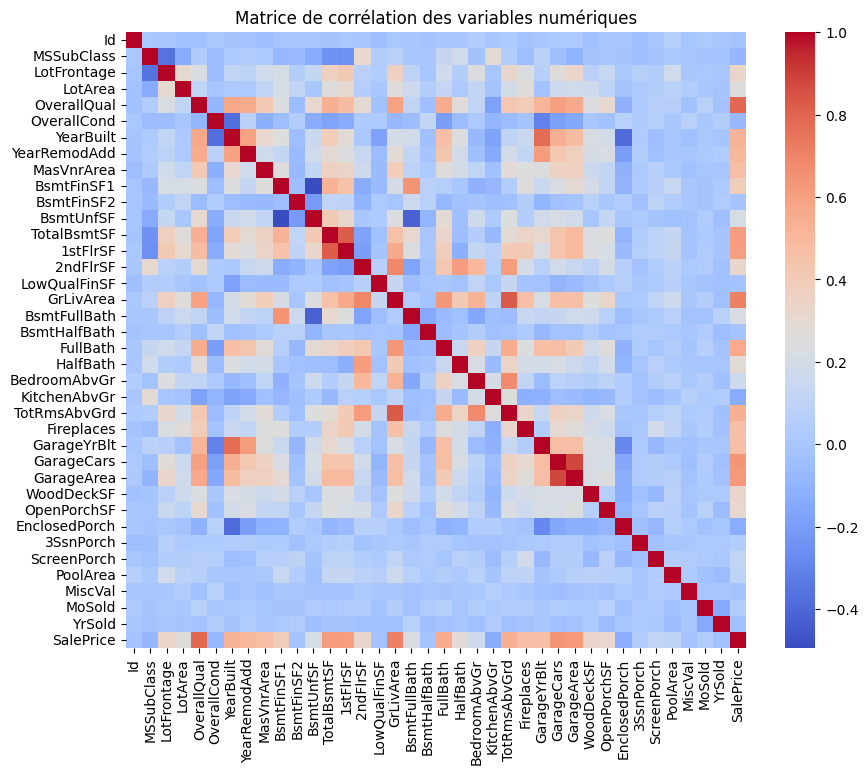

In [7]:
# Sélectionner uniquement les colonnes numériques
df_numeric = df.select_dtypes(include=["number"])

# Calculer la matrice de corrélation uniquement sur ces colonnes
correlation_matrix = df_numeric.corr()

# Trier les variables les plus corrélées avec SalePrice
correlation_with_price = correlation_matrix["SalePrice"].sort_values(ascending=False)

# Afficher les 15 variables les plus corrélées avec SalePrice
print("Top 15 des variables les plus corrélées avec SalePrice :")
print(correlation_with_price.head(15))

# Visualisation de la heatmap de corrélation

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Matrice de corrélation des variables numériques")
plt.show()

In [8]:
cat_cols = ["MSZoning", "Neighborhood", "BldgType", "HouseStyle",
            "RoofStyle", "Heating", "GarageType", "SaleCondition"]

# Compter le nombre de catégories uniques pour chaque colonne
for col in cat_cols:
    print(f"{col} : {df[col].nunique()} catégories uniques")

MSZoning : 5 catégories uniques
Neighborhood : 25 catégories uniques
BldgType : 5 catégories uniques
HouseStyle : 8 catégories uniques
RoofStyle : 6 catégories uniques
Heating : 6 catégories uniques
GarageType : 7 catégories uniques
SaleCondition : 6 catégories uniques


In [9]:
# Liste des colonnes catégoriques à encoder
cat_cols = ["MSZoning", "Neighborhood", "BldgType", "HouseStyle",
            "RoofStyle", "Heating", "GarageType", "SaleCondition"]

# Appliquer l'encodage One-Hot et supprimer la première colonne de chaque catégorie (drop_first=True)
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Vérifier le nouveau nombre de colonnes
print("Nombre de colonnes après encodage :", df_encoded.shape[1])

# Afficher un aperçu des nouvelles colonnes
print(df_encoded.head())

Nombre de colonnes après encodage : 129
   Id  MSSubClass  LotFrontage  LotArea Street LotShape LandContour Utilities  \
0   1          60         65.0     8450   Pave      Reg         Lvl    AllPub   
1   2          20         80.0     9600   Pave      Reg         Lvl    AllPub   
2   3          60         68.0    11250   Pave      IR1         Lvl    AllPub   
3   4          70         60.0     9550   Pave      IR1         Lvl    AllPub   
4   5          60         84.0    14260   Pave      IR1         Lvl    AllPub   

  LotConfig LandSlope  ... GarageType_Basment GarageType_BuiltIn  \
0    Inside       Gtl  ...              False              False   
1       FR2       Gtl  ...              False              False   
2    Inside       Gtl  ...              False              False   
3    Corner       Gtl  ...              False              False   
4       FR2       Gtl  ...              False              False   

   GarageType_CarPort  GarageType_Detchd  GarageType_None  \
0  

Top 15 des variables les plus corrélées avec SalePrice :
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
BsmtFinSF1      0.386420
Name: SalePrice, dtype: float64


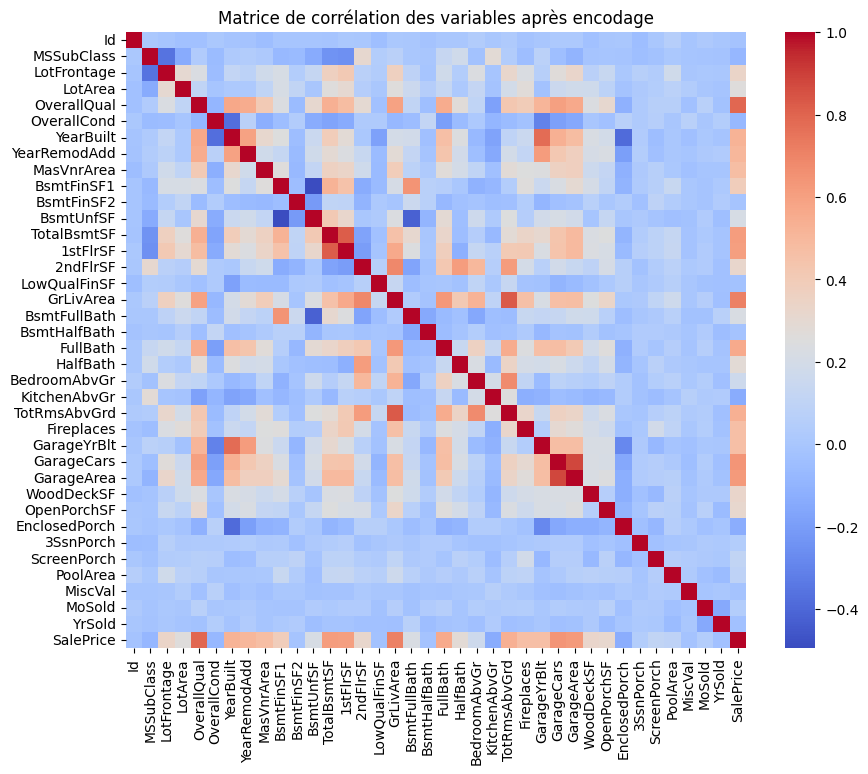

In [10]:
# Sélectionner uniquement les colonnes numériques après encodage
df_numeric = df_encoded.select_dtypes(include=["number"])

# Calculer la matrice de corrélation
correlation_matrix = df_numeric.corr()

# Trier les variables les plus corrélées avec SalePrice
correlation_with_price = correlation_matrix["SalePrice"].sort_values(ascending=False)

# Afficher les 15 variables les plus corrélées avec SalePrice
print("Top 15 des variables les plus corrélées avec SalePrice :")
print(correlation_with_price.head(15))

# Visualisation de la heatmap de corrélation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Matrice de corrélation des variables après encodage")
plt.show()

In [11]:
A = correlation_matrix

print(A)

                     Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
Id             1.000000    0.011156    -0.009921 -0.033226    -0.028365   
MSSubClass     0.011156    1.000000    -0.356718 -0.139781     0.032628   
LotFrontage   -0.009921   -0.356718     1.000000  0.304522     0.234812   
LotArea       -0.033226   -0.139781     0.304522  1.000000     0.105806   
OverallQual   -0.028365    0.032628     0.234812  0.105806     1.000000   
OverallCond    0.012609   -0.059316    -0.053281 -0.005636    -0.091932   
YearBuilt     -0.012713    0.027850     0.116685  0.014228     0.572323   
YearRemodAdd  -0.021998    0.040581     0.083348  0.013788     0.550684   
MasVnrArea    -0.051071    0.023573     0.178469  0.103321     0.407252   
BsmtFinSF1    -0.005024   -0.069836     0.214367  0.214103     0.239666   
BsmtFinSF2    -0.005968   -0.065649     0.042463  0.111170    -0.059119   
BsmtUnfSF     -0.007940   -0.140759     0.124098 -0.002618     0.308159   
TotalBsmtSF   -0.015415  

In [12]:
# Sélection des variables les plus pertinentes
features = ["OverallQual", "GrLivArea", "GarageCars", "GarageArea",
            "TotalBsmtSF", "1stFlrSF", "FullBath", "TotRmsAbvGrd",
            "YearBuilt", "YearRemodAdd", "MasVnrArea", "Fireplaces",
            "GarageYrBlt", "BsmtFinSF1"]

# Création du dataset final avec les variables sélectionnées
X = df_encoded[features]  # Variables explicatives
y = df_encoded["SalePrice"]  # Variable cible

# Division des données en entraînement (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Taille de l'ensemble d'entraînement :", X_train.shape)
print("Taille de l'ensemble de test :", X_test.shape)

Taille de l'ensemble d'entraînement : (1168, 14)
Taille de l'ensemble de test : (292, 14)


In [13]:
# Initialiser et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

# Afficher les résultats
print(f"Mean Absolute Error (MAE) : {mae}")
print(f"Mean Squared Error (MSE) : {mse}")
print(f"Root Mean Squared Error (RMSE) : {rmse}")
print(f"R² Score : {r2}")

Mean Absolute Error (MAE) : 24369.205346237166
Mean Squared Error (MSE) : 1446064584.0711977
Root Mean Squared Error (RMSE) : 38027.15587670471
R² Score : 0.8114728702520853


In [14]:
# Initialiser le modèle Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner le modèle sur l'ensemble d'entraînement
rf_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

# Évaluer le modèle
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Afficher les résultats
print(f"Random Forest - Mean Absolute Error (MAE) : {mae_rf}")
print(f"Random Forest - Mean Squared Error (MSE) : {mse_rf}")
print(f"Random Forest - Root Mean Squared Error (RMSE) : {rmse_rf}")
print(f"Random Forest - R² Score : {r2_rf}")

Random Forest - Mean Absolute Error (MAE) : 18653.3353196347
Random Forest - Mean Squared Error (MSE) : 882236283.4109868
Random Forest - Root Mean Squared Error (RMSE) : 29702.462581593918
Random Forest - R² Score : 0.8849806045296577


C:\Users\Sarah\AppData\Local\Temp\ipykernel_19684\884825339.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance_df.Importance[:10], y=feature_importance_df.Feature[:10], palette="viridis")


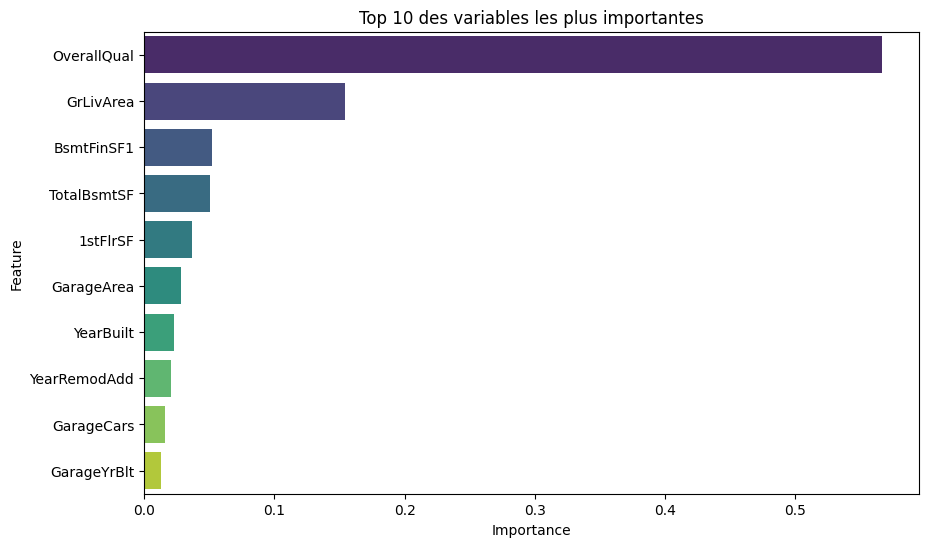

         Feature  Importance
0    OverallQual    0.566572
1      GrLivArea    0.153926
13    BsmtFinSF1    0.052318
4    TotalBsmtSF    0.050358
5       1stFlrSF    0.036458
3     GarageArea    0.028216
8      YearBuilt    0.023311
9   YearRemodAdd    0.020609
2     GarageCars    0.016267
12   GarageYrBlt    0.013125
7   TotRmsAbvGrd    0.012523
6       FullBath    0.011004
10    MasVnrArea    0.008607
11    Fireplaces    0.006708


In [15]:
# Récupérer l'importance des variables
importances = rf_model.feature_importances_

# Créer un DataFrame pour les afficher proprement
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Afficher les 10 variables les plus importantes
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance_df.Importance[:10], y=feature_importance_df.Feature[:10], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 des variables les plus importantes")
plt.show()

# Afficher le classement complet
print(feature_importance_df)

In [16]:
# Définir la grille de paramètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],  # Nombre d'arbres
    'max_depth': [None, 10, 20],  # Profondeur max des arbres
    'min_samples_split': [2, 5, 10],  # Nombre min d’échantillons pour diviser un nœud
    'min_samples_leaf': [1, 2, 4]  # Nombre min d’échantillons dans une feuille
}

# Initialiser le modèle
rf = RandomForestRegressor(random_state=42)

# GridSearchCV pour tester toutes les combinaisons
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Meilleurs paramètres trouvés
print("Meilleurs paramètres :", grid_search.best_params_)

# Tester avec ces paramètres optimisés
best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_best_rf = best_rf.predict(X_test)

# Évaluer le modèle optimisé
r2_best_rf = r2_score(y_test, y_pred_best_rf)
print("R² Score après optimisation :", r2_best_rf)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Meilleurs paramètres : {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
R² Score après optimisation : 0.8706196534122013


In [17]:
# Prédictions avec le modèle optimisé
y_pred_optimized = best_rf.predict(X_test)

# Évaluation des erreurs
mae_optimized = mean_absolute_error(y_test, y_pred_optimized)
mse_optimized = mean_squared_error(y_test, y_pred_optimized)
rmse_optimized = mse_optimized ** 0.5

# Afficher les résultats
print(f"Optimized Random Forest - Mean Absolute Error (MAE) : {mae_optimized}")
print(f"Optimized Random Forest - Mean Squared Error (MSE) : {mse_optimized}")
print(f"Optimized Random Forest - Root Mean Squared Error (RMSE) : {rmse_optimized}")

Optimized Random Forest - Mean Absolute Error (MAE) : 18855.740721230446
Optimized Random Forest - Mean Squared Error (MSE) : 992389463.127346
Optimized Random Forest - Root Mean Squared Error (RMSE) : 31502.213622654297


In [18]:
# Initialiser le modèle XGBoost
xgb_model = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)

# Entraîner le modèle
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = mse_xgb ** 0.5
r2_xgb = r2_score(y_test, y_pred_xgb)

# Afficher les résultats
print(f"XGBoost - Mean Absolute Error (MAE) : {mae_xgb}")
print(f"XGBoost - Mean Squared Error (MSE) : {mse_xgb}")
print(f"XGBoost - Root Mean Squared Error (RMSE) : {rmse_xgb}")
print(f"XGBoost - R² Score : {r2_xgb}")

XGBoost - Mean Absolute Error (MAE) : 18853.751953125
XGBoost - Mean Squared Error (MSE) : 836860672.0
XGBoost - Root Mean Squared Error (RMSE) : 28928.544242668002
XGBoost - R² Score : 0.8908963203430176


In [19]:
# Définir une grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9]
}

# Création du modèle XGBoost
xgb = XGBRegressor(random_state=42)

# GridSearchCV pour tester les combinaisons
grid_search_xgb = GridSearchCV(xgb, param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search_xgb.fit(X_train, y_train)

# Afficher les meilleurs paramètres
print("Meilleurs paramètres XGBoost :", grid_search_xgb.best_params_)

# Tester avec ces paramètres optimisés
best_xgb = XGBRegressor(**grid_search_xgb.best_params_, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred_best_xgb = best_xgb.predict(X_test)

# Évaluer le modèle optimisé
r2_best_xgb = r2_score(y_test, y_pred_best_xgb)
print("R² Score après optimisation de XGBoost :", r2_best_xgb)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Meilleurs paramètres XGBoost : {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
R² Score après optimisation de XGBoost : 0.8916681408882141


In [20]:
# Comparer prédictions et vraies valeurs
errors = np.abs(y_test - y_pred_best_xgb)

# Afficher les 10 pires erreurs
worst_predictions = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_best_xgb, "Error": errors})
worst_predictions = worst_predictions.sort_values(by="Error", ascending=False)
print("🔍 Top 10 des pires erreurs :")
print(worst_predictions.head(10))

🔍 Top 10 des pires erreurs :
      Actual     Predicted         Error
691   755000  595257.25000  159742.75000
898   611657  464552.59375  147104.40625
581   253293  394244.62500  140951.62500
774   395000  291772.40625  103227.59375
1046  556581  461347.15625   95233.84375
451   280000  193399.21875   86600.78125
218   311500  228976.40625   82523.59375
261   276000  357089.25000   81089.25000
426   275000  205659.00000   69341.00000
529   200624  261971.37500   61347.37500


C:\Users\Sarah\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


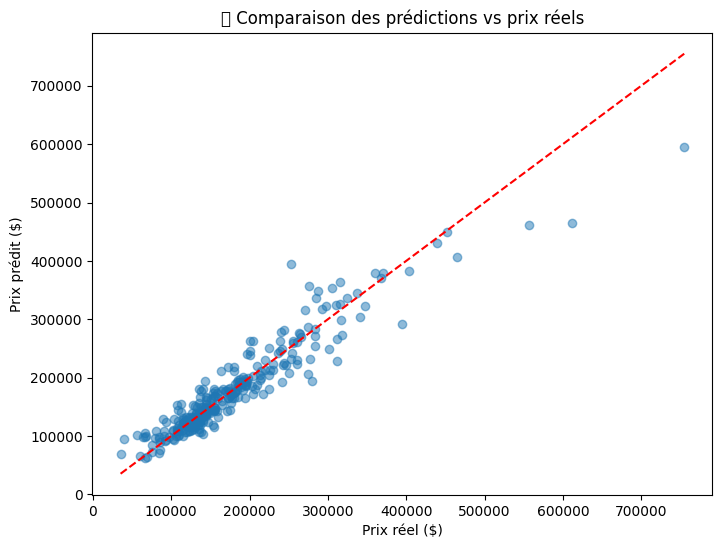

In [21]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_best_xgb, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red')  # Ligne idéale y = x
plt.xlabel("Prix réel ($)")
plt.ylabel("Prix prédit ($)")
plt.title("🔍 Comparaison des prédictions vs prix réels")
plt.show()

In [31]:
joblib.dump(best_xgb, "xgboost_model.pkl")
print("✅ Modèle XGBoost sauvegardé sous 'xgboost_model.pkl'")

✅ Modèle XGBoost sauvegardé sous 'xgboost_model.pkl'


In [32]:
print("Maisons à plus de 500K$ :", sum(y_train > 500000))

Maisons à plus de 500K$ : 6


In [22]:
# Transformation log du prix
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

# Réentraîner XGBoost avec les prix transformés
xgb_log = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
xgb_log.fit(X_train, y_train_log)
y_pred_log = xgb_log.predict(X_test)

# Reconvertir les prédictions avec exp()
y_pred_final = np.exp(y_pred_log)

# Recalculer les erreurs
mae_log = mean_absolute_error(y_test, y_pred_final)
r2_log = r2_score(y_test, y_pred_final)

print(f"✅ MAE après transformation log : {mae_log}")
print(f"✅ R² Score après transformation log : {r2_log}")

✅ MAE après transformation log : 18821.130859375
✅ R² Score après transformation log : 0.8893975615501404


In [23]:
# Extraire les maisons à plus de 500K$
expensive_houses = X_train[y_train > 500000]
expensive_prices = y_train[y_train > 500000]

# Ajouter ces maisons plusieurs fois dans l'entraînement
X_train_balanced = pd.concat([X_train] + [expensive_houses] * 10, axis=0)
y_train_balanced = pd.concat([y_train] + [expensive_prices] * 10, axis=0)

# Réentraîner XGBoost avec ces nouvelles données
xgb_balanced = XGBRegressor(n_estimators=300, learning_rate=0.05, max_depth=3, random_state=42)
xgb_balanced.fit(X_train_balanced, y_train_balanced)
y_pred_balanced = xgb_balanced.predict(X_test)

# Évaluer
r2_balanced = r2_score(y_test, y_pred_balanced)
print(f"✅ R² Score après augmentation des maisons chères : {r2_balanced}")

✅ R² Score après augmentation des maisons chères : 0.8952150344848633


In [24]:
# Initialiser le modèle
catboost_model = CatBoostRegressor(iterations=300, depth=6, learning_rate=0.05, random_seed=42, verbose=0)

# Entraîner le modèle
catboost_model.fit(X_train, y_train)

# Prédictions
y_pred_catboost = catboost_model.predict(X_test)

# Évaluation
r2_catboost = r2_score(y_test, y_pred_catboost)
print(f"✅ R² Score avec CatBoost : {r2_catboost}")

✅ R² Score avec CatBoost : 0.8970582629937167


In [28]:
joblib.dump(catboost_model, "catboost_best_model.pkl")
print("✅ Modèle CatBoost sauvegardé sous 'catboost_best_model.pkl'")

✅ Modèle CatBoost sauvegardé sous 'catboost_best_model.pkl'


In [38]:
# Sélectionner uniquement les colonnes de type "object" (catégoriques)
cat_features = df.select_dtypes(include=["object"]).columns.tolist()

# Remplacer les NaN des colonnes catégoriques par une valeur par défaut
X_train[cat_features] = X_train[cat_features].fillna("Missing")
X_test[cat_features] = X_test[cat_features].fillna("Missing")

print("✅ Valeurs manquantes remplacées dans les colonnes catégoriques")


print("Colonnes catégoriques détectées :", cat_features)

✅ Valeurs manquantes remplacées dans les colonnes catégoriques
Colonnes catégoriques détectées : ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [40]:
# Utiliser toutes les colonnes catégoriques détectées
cat_features = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 
   'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
   'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 
   'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 
   'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']

# Initialiser CatBoost avec les données corrigées
catboost_native = CatBoostRegressor(
    iterations=300, 
    depth=6, 
    learning_rate=0.05, 
    cat_features=cat_features,  # Passer la liste corrigée
    random_seed=42, 
    verbose=0
)

# Entraîner le modèle
catboost_native.fit(X_train, y_train)

# Faire des prédictions
y_pred_catboost_native = catboost_native.predict(X_test)

# Évaluer la performance
r2_catboost_native = r2_score(y_test, y_pred_catboost_native)
print(f"✅ R² Score avec CatBoost sans One-Hot Encoding : {r2_catboost_native}")

CatBoostError: Bad value for num_feature[non_default_doc_idx=4,feature_idx=6]="Pave": Cannot convert 'b'Pave'' to float

Colonnes disponibles dans X : ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'Scre

In [36]:
# Détecter automatiquement les colonnes catégoriques (object + certaines numériques)
cat_features = X_train.select_dtypes(include=["object"]).columns.tolist()

# Ajouter manuellement les colonnes numériques qui sont en réalité des catégories
cat_features += ["MSSubClass", "MoSold", "YrSold"]  # Exemples : Mois et année de vente, type de maison

print("Colonnes catégoriques utilisées par CatBoost :", cat_features)

Colonnes catégoriques utilisées par CatBoost : ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition', 'MSSubClass', 'MoSold', 'YrSold']


✅ Toutes les valeurs NaN ont été remplacées


CatBoostError: Bad value for num_feature[non_default_doc_idx=4,feature_idx=6]="Pave": Cannot convert 'b'Pave'' to float